## GRACE simulation

In [1]:
# Imports
from gfeatpy import plotting
from gfeatpy.observation import Range
from gfeatpy.gravity import EquivalentWaterHeight, GravityField, SphericalHarmonicsCovariance
import matplotlib.pyplot as plt
import numpy as np

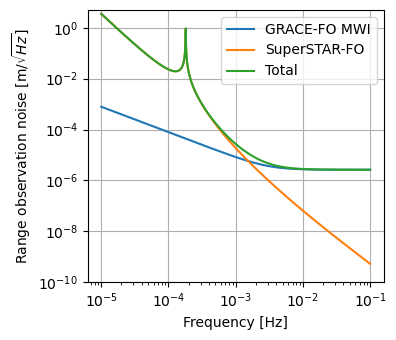

In [2]:
# Define error spectra
mwi = lambda f: 2.62 * np.sqrt(1 + (0.003/f)**2) * 1e-6
acc = lambda f: 1e-10 * np.sqrt(1 + (f/0.5)**4 + (0.005/f))

# Plot spectra
plt.figure(figsize=(4,3.5))
f = np.logspace(-5, -1, 1000)
n = np.sqrt(3.986e14 / (6771e3)**3)
w = f * (2*np.pi)
mwi_asd = mwi(f)
acc_asd = 2 * (np.abs(2*n / (w * (n**2 - w**2))) + np.abs((3*n**2 + w**2) / (w**2 * (n**2 - w**2)))) * acc(f)
plt.loglog(f, mwi_asd, label="GRACE-FO MWI")
plt.loglog(f, acc_asd, label="SuperSTAR-FO")
plt.loglog(f, mwi_asd + acc_asd, label="Total")
plt.ylabel('Range observation noise [m/$\\sqrt{{Hz}}$]')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.ylim([1e-10, 5])
plt.show()

In [3]:
# Define observation settings
l_max = 96
Nr = 399
Nd = 26
I = np.deg2rad(89)
rho= 220e3
# Set up system and solve
range = Range(l_max, Nr, Nd, I, rho)
range.set_observation_error(mwi, acc)
range.set_solution_time_window(30)
range.solve()

In [4]:
# Load gravity field data
data_root = "../../../data"  # data directory location
year = 2007                   # define monthly solution to load from ITSG
month = 3
static = GravityField(l_max).load(f"{data_root}/gravity/static/GOCO05c.gfc")
itgs_version = "ITSG-Grace2018"  
temporal = GravityField(l_max).load(
    f"{data_root}/gravity/monthly/{itgs_version}_n{l_max}_{year}-{month:02d}.gfc") 
temporal.coefficients = temporal.coefficients - static.coefficients
temporal_error = SphericalHarmonicsCovariance(l_max).from_normal(
    f"{data_root}/gravity/monthly_normals/{itgs_version}_n{l_max}_{year}-{month:02d}.snx", 1) 
# Compute RMS for signal and error
signal = temporal.rms_per_coefficient_per_degree(use_sigmas=False)[2:]
error = temporal_error.rms_per_coefficient_per_degree()[2:]

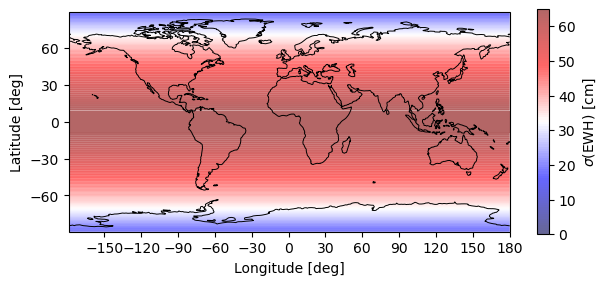

In [5]:
# Plot results
plotting.synthesis(range, 360, 180, EquivalentWaterHeight(0))
plt.show()

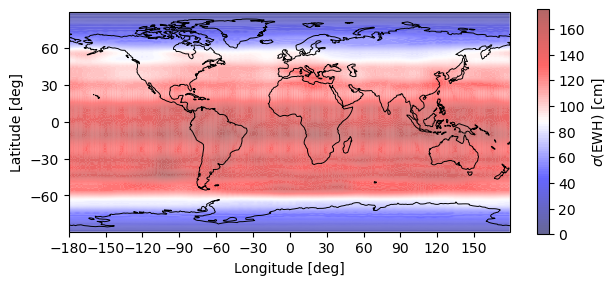

In [6]:
plotting.synthesis(temporal_error, 360, 180, EquivalentWaterHeight(0))
plt.show()

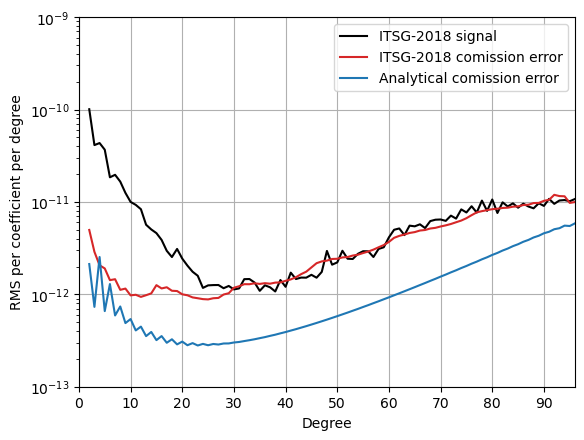

In [7]:
# Compare with operational results
degree = np.arange(2, l_max+0.5, 1)
plt.semilogy(degree, signal, 'k')
plt.semilogy(degree, error, color='tab:red')
plt.semilogy(degree, range.rms_per_coefficient_per_degree()[2:], color='tab:blue')
plt.legend(['ITSG-2018 signal', 'ITSG-2018 comission error', 'Analytical comission error'])
plt.ylim([1e-13, 1e-9])
plt.xlim([0,96])
plt.xticks(np.arange(0,91,10))
plt.ylabel('RMS per coefficient per degree')
plt.xlabel('Degree')
plt.grid()
plt.show()